# MPC Surrogate Training Pipeline

This notebook implements the complete training and evaluation pipeline for approximating MPC policies using neural networks.

## Dataset Structure
- **States**: Joint positions and velocities (6D) - [q1, q2, q3, q̇1, q̇2, q̇3]
- **Targets**: End-effector target positions (3D) - [x, y, z]
- **Actions**: MPC torques (3D) - [τ1, τ2, τ3]

The goal is to learn a mapping: (state, target) → MPC torques

In [ ]:
# Install dependencies
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install h5py numpy matplotlib scikit-learn tqdm

In [8]:
!ls -lh robot_mpc_dataset.h5

-rw-r--r-- 1 root root 24M Nov 22 22:55 robot_mpc_dataset.h5


In [25]:
import json
import os
import random
import time

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm


def compute_direction_accuracy(y_true, y_pred):
    """
    Sum the number of time the sign of the predicted torque matches the true torque.
    """
    return np.sum(np.sign(y_true) == np.sign(y_pred)) / (3 * len(y_true))


torch.manual_seed(42)
np.random.seed(42)

DATA_PATH = "robot_mpc_dataset.h5"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## Data Preparation - Visualization

In [22]:
class MPCDataset(Dataset):
    def __init__(self, filepath, episode_keys, mode="mlp", augment=False):
        """
        mode: 'mlp' (flattens trajectories) or 'rnn' (keeps trajectories intact)
        """
        super().__init__()
        self.augment = augment
        self.mode = mode
        self.data = []  # (inputs, actions) tuples

        with h5py.File(filepath, "r") as f:
            grp_eps = f["episodes"]
            for ep in episode_keys:
                # Load raw data
                s = torch.from_numpy(grp_eps[ep]["states"][:]).float()  # (T, 6)
                t = torch.from_numpy(grp_eps[ep]["targets"][:]).float()  # (T, 3)
                a = torch.from_numpy(grp_eps[ep]["actions"][:]).float()  # (T, 3)

                # states + targets as input -> (T, 9)
                inp = torch.cat([s, t], dim=-1)
                self.data.append((inp, a))

        # if MLP, flatten all steps from these specific episodes into one tensor
        if self.mode == "mlp":
            self.inputs = torch.cat([x[0] for x in self.data], dim=0)
            self.actions = torch.cat([x[1] for x in self.data], dim=0)

    def __len__(self):
        return len(self.inputs) if self.mode == "mlp" else len(self.data)

    def __getitem__(self, idx):
        if self.mode == "mlp":
            x, y = self.inputs[idx], self.actions[idx]  # (9,), (3,)
            if self.augment:
                x[:6] += torch.randn(6) * 0.01  # noise on state
                y += torch.randn(3) * 0.005  # noise on action
            return x, y

        # RNN
        else:
            x, y = self.data[idx]  # (T, 9), (T, 3)
            if self.augment:
                noise_x = torch.randn_like(x)
                noise_x[:, 6:] = 0  # no noise on targets
                x = x + (noise_x * 0.01)
                y = y + (torch.randn_like(y) * 0.005)
            return x, y


def collate_rnn(batch):
    inputs, actions = zip(*batch)
    lengths = torch.tensor([x.size(0) for x in inputs])

    # pad variable lengths (T0, T1...) to max length in batch
    padded_inputs = pad_sequence(inputs, batch_first=True)  # (B, T_max, 9)
    padded_actions = pad_sequence(actions, batch_first=True)  # (B, T_max, 3)

    return padded_inputs, padded_actions, lengths


def create_dataloaders(filepath, train_ratio=0.8, batch_size=32, dataset_type="mlp"):
    # split by episode idx
    with h5py.File(filepath, "r") as f:
        keys = np.array(sorted(f["episodes"].keys()))

    np.random.shuffle(keys)
    split = int(len(keys) * train_ratio)
    train_keys, val_keys = keys[:split], keys[split:]

    if dataset_type == "mlp":
        train_ds_mlp = MPCDataset(filepath, train_keys, mode="mlp", augment=True)
        val_ds_mlp = MPCDataset(filepath, val_keys, mode="mlp", augment=False)

        train = DataLoader(train_ds_mlp, batch_size=batch_size, shuffle=True)
        val = DataLoader(val_ds_mlp, batch_size=batch_size, shuffle=False)
    elif dataset_type == "rnn":
        train_ds_rnn = MPCDataset(filepath, train_keys, mode="rnn", augment=True)
        val_ds_rnn = MPCDataset(filepath, val_keys, mode="rnn", augment=False)

        train = DataLoader(train_ds_rnn, batch_size=batch_size, shuffle=True, collate_fn=collate_rnn)
        val = DataLoader(val_ds_rnn, batch_size=batch_size, shuffle=False, collate_fn=collate_rnn)

    return train, val

# Data vizualization

Visualizing episode 485


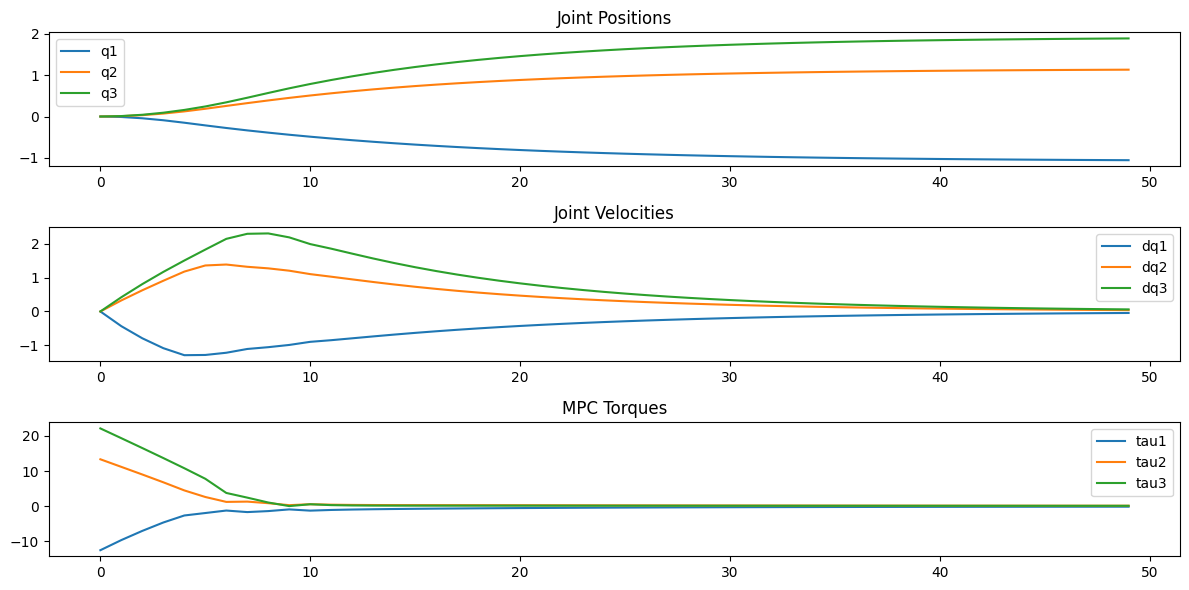

In [10]:
episodes = []
with h5py.File(DATA_PATH, "r") as f:
    keys = np.array(sorted(f["episodes"].keys()))
    for ep in keys:
        grp = f["episodes"][ep]
        states = grp["states"][:]
        targets = grp["targets"][:]
        actions = grp["actions"][:]
        episodes.append((states, targets, actions))

# pick a random episode
ep_idx = random.randint(0, len(episodes) - 1)
episode = episodes[ep_idx]
ep_states = episode[0]
ep_targets = episode[1]
ep_actions = episode[2]

print(f"Visualizing episode {ep_idx}")

# joint positions
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(ep_states[:, 0], label="q1")
plt.plot(ep_states[:, 1], label="q2")
plt.plot(ep_states[:, 2], label="q3")
plt.title("Joint Positions")
plt.legend()

# joint velocities
plt.subplot(3, 1, 2)
plt.plot(ep_states[:, 3], label="dq1")
plt.plot(ep_states[:, 4], label="dq2")
plt.plot(ep_states[:, 5], label="dq3")
plt.title("Joint Velocities")
plt.legend()

# MPC actions
plt.subplot(3, 1, 3)
plt.plot(ep_actions[:, 0], label="tau1")
plt.plot(ep_actions[:, 1], label="tau2")
plt.plot(ep_actions[:, 2], label="tau3")
plt.title("MPC Torques")
plt.legend()

plt.tight_layout()
plt.show()

## Model Architectures

In [24]:
class MLP(nn.Module):
    """Simple Multi-Layer Perceptron"""

    def __init__(self, input_dim=9, hidden_dims=[128, 64], output_dim=3):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([nn.Linear(prev_dim, hidden_dim), nn.ReLU(), nn.BatchNorm1d(hidden_dim), nn.Dropout(0.1)])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class LSTM(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, num_layers=2, output_dim=3):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths=None):
        # x: (B, T, input_dim)
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out)  # (B, T, output_dim)
        return out


class GRU(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, num_layers=2, output_dim=3):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths=None):
        out, hn = self.gru(x)
        out = self.fc(out)
        return out


model_configs = {
    "MLP": {"class": MLP, "params": {"hidden_dims": [128, 64]}, "dataset_type": "mlp"},
    "LSTM": {"class": LSTM, "params": {"hidden_dim": 128, "num_layers": 2}, "dataset_type": "rnn"},
    "GRU": {"class": GRU, "params": {"hidden_dim": 128, "num_layers": 2}, "dataset_type": "rnn"},
}

print("Available models:", list(model_configs.keys()))

Available models: ['MLP']


## Training and Evaluation Functions

In [31]:
def train_epoch(model, train_loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    num_batches = 0

    for batch in train_loader:
        if len(batch) == 3:
            inputs, targets, lengths = batch
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs, lengths)
        else:
            inputs, targets = batch
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)

        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches


def evaluate(model, test_loader, criterion):
    """Evaluate model on test set"""
    model.eval()
    total_loss = 0
    num_batches = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            if len(batch) == 3:
                inputs, targets, lengths = batch
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs, lengths)
            else:
                inputs, targets = batch
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)

            loss = criterion(outputs, targets)

            total_loss += loss.item()
            num_batches += 1

            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    predictions = np.concatenate(all_predictions)
    targets = np.concatenate(all_targets)

    # Flatten for metrics calculation if RNN
    if predictions.ndim == 3:
        predictions = predictions.reshape(-1, predictions.shape[-1])
        targets = targets.reshape(-1, targets.shape[-1])

    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    da = compute_direction_accuracy(targets, predictions)
    ev = explained_variance_score(targets, predictions)

    return {
        "loss": total_loss / num_batches,
        "mse": mse,
        "mae": mae,
        "direction_accuracy": da,
        "explained_variance": ev,
        "predictions": predictions,
        "targets": targets,
    }


def train_model(model_name, model, train_loader, test_loader, num_epochs=100, patience=10):
    """Complete training pipeline for a model"""
    print(f"\n=== Training {model_name} ===")

    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    mse_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)
    mae_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

    results = {
        "model_name": model_name,
        "hyperparameters": {"lr": 1e-3, "weight_decay": 1e-4, "batch_size": train_loader.batch_size, "num_epochs": num_epochs},
        "training_history": [],
        "best_mse_results": None,
        "best_mae_results": None,
    }

    best_mse_loss = float("inf")
    best_mae_loss = float("inf")
    patience_counter = 0

    # tqdm progress bar for epochs
    pbar = tqdm(range(num_epochs), desc=f"Training {model_name}")

    try:
        for epoch in pbar:
            start_time = time.time()

            # Train with MSE
            train_loss_mse = train_epoch(model, train_loader, mse_criterion, optimizer)
            mse_results = evaluate(model, test_loader, mse_criterion)

            # Train with MAE
            train_loss_mae = train_epoch(model, train_loader, mae_criterion, optimizer)
            mae_results = evaluate(model, test_loader, mae_criterion)

            # Update schedulers
            mse_scheduler.step(mse_results["loss"])
            mae_scheduler.step(mae_results["loss"])

            epoch_time = time.time() - start_time

            # Update tqdm display
            pbar.set_postfix({"mse": mse_results["loss"], "mae": mae_results["loss"], "time": f"{epoch_time:.2f}s"})

            # Log results
            epoch_results = {
                "epoch": epoch + 1,
                "train_loss_mse": train_loss_mse,
                "test_loss_mse": mse_results["loss"],
                "test_mse": mse_results["mse"],
                "test_mae": mse_results["mae"],
                "train_loss_mae": train_loss_mae,
                "test_loss_mae": mae_results["loss"],
                "test_direction_accuracy": mse_results["direction_accuracy"],
                "test_explained_variance": mse_results["explained_variance"],
                "epoch_time": epoch_time,
            }
            results["training_history"].append(epoch_results)

            # Save best models
            if mse_results["loss"] < best_mse_loss:
                best_mse_loss = mse_results["loss"]
                results["best_mse_results"] = mse_results.copy()
                torch.save(model.state_dict(), f"{model_name}_best_mse.pth")

            if mae_results["loss"] < best_mae_loss:
                best_mae_loss = mae_results["loss"]
                results["best_mae_results"] = mae_results.copy()
                torch.save(model.state_dict(), f"{model_name}_best_mae.pth")

            # Early stopping logic
            if mse_results["loss"] >= best_mse_loss:
                patience_counter += 1
            else:
                patience_counter = 0

            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch + 1}")
                break

    except KeyboardInterrupt:
        print("\nTraining interrupted by user. Saving current results...")

    return results

## Run Training Pipeline

In [ ]:
all_results = {}

for model_name, config in model_configs.items():
    model_class = config["class"]
    model_params = config["params"]
    dataset_type = config["dataset_type"]

    train_loader, val_loader = create_dataloaders(DATA_PATH, train_ratio=0.8, batch_size=32, dataset_type=dataset_type)
    model = model_class(**model_params).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"\n{model_name} - Parameters: {total_params:,}")

    # Train model
    results = train_model(model_name, model, train_loader, val_loader, num_epochs=50)
    all_results[model_name] = results

print("\n=== Training Complete ===")


MLP - Parameters: 10,115

=== Training MLP ===


Training MLP:   4%|▍         | 2/50 [00:34<13:58, 17.47s/it, mse=1.6, mae=0.489, time=17.34s]

## Export Results

In [ ]:
# Create results directory
os.makedirs("results", exist_ok=True)

# Export comprehensive results
for model_name, results in all_results.items():
    # Save detailed results as JSON
    results_file = f"results/{model_name}_results.json"
    with open(results_file, "w") as f:
        # Convert numpy arrays to lists for JSON serialization
        json_results = results.copy()
        if "best_mse_results" in json_results and json_results["best_mse_results"]:
            json_results["best_mse_results"].pop("predictions", None)
            json_results["best_mse_results"].pop("targets", None)
        if "best_mae_results" in json_results and json_results["best_mae_results"]:
            json_results["best_mae_results"].pop("predictions", None)
            json_results["best_mae_results"].pop("targets", None)
        json.dump(json_results, f, indent=2)

    print(f"Results saved to: {results_file}")

# Export summary table
summary_data = []
for model_name, results in all_results.items():
    row = {
        "model_type": model_name,
        "hyperparameters": results["hyperparameters"],
        "best_mse_loss": results.get("best_mse_results", {}).get("loss", "N/A"),
        "best_mae_loss": results.get("best_mae_results", {}).get("loss", "N/A"),
        "best_mse_mse": results.get("best_mse_results", {}).get("mse", "N/A"),
        "best_mae_mae": results.get("best_mae_results", {}).get("mae", "N/A"),
        "epochs_trained": len(results["training_history"]),
    }
    summary_data.append(row)

with open("results/training_summary.json", "w") as f:
    json.dump(summary_data, f, indent=2)

print("Summary saved to: results/training_summary.json")

# Export model weights (already saved during training)
print("Model weights saved as .pth files")

## Results Visualization

In [ ]:
# Plot training curves
plt.figure(figsize=(15, 10))

for i, (model_name, results) in enumerate(all_results.items()):
    history = results["training_history"]

    epochs = [h["epoch"] for h in history]
    mse_losses = [h["test_loss_mse"] for h in history]
    mae_losses = [h["test_loss_mae"] for h in history]

    plt.subplot(2, 2, 1)
    plt.plot(epochs, mse_losses, label=model_name)
    plt.title("MSE Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, mae_losses, label=model_name)
    plt.title("MAE Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("MAE Loss")
    plt.legend()

plt.tight_layout()
plt.savefig("results/training_curves.png", dpi=300, bbox_inches="tight")
plt.show()

# Print final results summary
print("\n=== Final Results Summary ===")
print(f"{'Model':<12} {'MSE Loss':<10} {'MAE Loss':<10} {'MSE':<10} {'MAE':<10}")
print("-" * 60)

for model_name, results in all_results.items():
    mse_results = results.get("best_mse_results", {})
    mae_results = results.get("best_mae_results", {})

    mse_loss = f"{mse_results.get('loss', 'N/A'):.6f}" if mse_results else "N/A"
    mae_loss = f"{mae_results.get('loss', 'N/A'):.6f}" if mae_results else "N/A"
    mse_val = f"{mse_results.get('mse', 'N/A'):.6f}" if mse_results else "N/A"
    mae_val = f"{mae_results.get('mae', 'N/A'):.6f}" if mae_results else "N/A"

    print(f"{model_name:<12} {mse_loss:<10} {mae_loss:<10} {mse_val:<10} {mae_val:<10}")

print("\nModel weights saved as .pth files")
print("Detailed results saved in results/ directory")

## Download Results

In [ ]:
# Create zip file for easy download
!zip -r mpc_surrogate_results.zip results/ *.pth

from google.colab import files

files.download("mpc_surrogate_results.zip")